In [14]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [15]:
dataset = TSD(categories=['sc'], file_path="../datasets/power_transitions.csv")
dataset.scv_imputed = pd.DataFrame()


Dataset loaded from ../datasets/power_transitions.xlsx


In [16]:
imp_columns =  ['Pop','Cap','Terr','Hierarchy', 'Government', 'Infrastructure', 'Information', 'Money']
dataset.impute_missing_values(imp_columns, use_duplicates=False)
sc_columns = ['Pop','Cap','Terr','Hierarchy', 'Government', 'Infrastructure', 'Information', 'Money']

In [17]:
dataset.scv.loc[(dataset.scv[imp_columns].isna().sum(axis=1)<6)]

,NGA,PolityID,PolityName,Year,Pop,Terr,Cap,Hierarchy,Government,Infrastructure,...,Weapon,Armor,Animal,Defense,Cavalry,Iron,IronCav,MSP,dataset,Hierarchy_sq
0,Middle Yellow River Valley,1,cn_qing_dyn_1,1661.0,8.009710,7.117271,5.865755,6.750000,0.888889,1.0,...,6.0,8.0,3.0,7.666667,1.0,1.0,1.0,0.9,PT,45.562500
1,Middle Yellow River Valley,1,cn_qing_dyn_1,1722.0,8.009710,7.117271,5.865755,6.750000,0.888889,1.0,...,6.0,8.0,3.0,7.666667,1.0,1.0,1.0,0.9,PT,45.562500
2,Middle Yellow River Valley,1,cn_qing_dyn_1,1735.0,8.009710,7.117271,5.865755,6.750000,0.888889,1.0,...,6.0,8.0,3.0,7.666667,1.0,1.0,1.0,0.9,PT,45.562500
3,Middle Yellow River Valley,1,cn_qing_dyn_1,1796.0,8.009710,7.117271,5.865755,6.750000,0.888889,1.0,...,6.0,8.0,3.0,7.666667,1.0,1.0,1.0,0.9,PT,45.562500
4,Middle Yellow River Valley,2,cn_qing_dyn_2,1820.0,8.469822,7.053078,5.949825,6.832772,0.909091,1.0,...,5.0,6.0,3.0,8.000000,1.0,1.0,1.0,0.9,PT,46.686771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13339,NaN,668,ni_nri_k,1800.0,NaN,NaN,NaN,2.750000,0.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25y,7.562500
13340,NaN,668,ni_nri_k,1825.0,NaN,NaN,NaN,2.750000,0.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25y,7.562500
13341,NaN,668,ni_nri_k,1850.0,NaN,NaN,NaN,2.750000,0.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25y,7.562500
13342,NaN,668,ni_nri_k,1875.0,NaN,NaN,NaN,2.750000,0.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25y,7.562500


In [18]:
crisis_vars = ['overturn',
              'predecessor_assassination'
              ,'intra_elite'
              ,'military_revolt'
              ,'popular_uprising'
              ,'separatist_rebellion'
              ,'external_invasion'
              ,'external_interference'
              ]
for var in crisis_vars:
    dataset.scv_imputed[var] = dataset.raw[var]
dataset.scv_imputed.dropna(subset=imp_columns, inplace=True)

In [23]:
pca = dataset.compute_PCA(imp_columns, 'PC', n_cols = 2, n_PCA = 8, contributions=True)
dataset.scv_imputed['PC_1'] = -dataset.scv_imputed['PC_1']

Explained variance by each PC:
PC1: 69.62%
PC2: 8.08%
PC3: 6.99%
PC4: 5.43%
PC5: 3.93%
PC6: 2.60%
PC7: 2.24%
PC8: 1.11%
PC1 contributions:
Pop: -0.39
Cap: -0.39
Terr: -0.36
Hierarchy: -0.31
Government: -0.37
Infrastructure: -0.34
Information: -0.34
Money: -0.33
PC1 contributions:
Pop: -0.27
Cap: -0.27
Terr: -0.13
Hierarchy: -0.02
Government: 0.04
Infrastructure: -0.42
Information: 0.58
Money: 0.56


<ErrorbarContainer object of 3 artists>

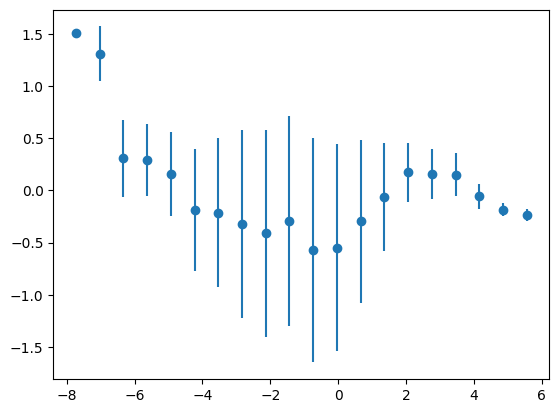

In [24]:
n_bins = 20
scv_imp = dataset.scv_imputed#.drop_duplicates(subset=imp_columns)
pc1 = np.linspace(scv_imp.PC_1.min(), scv_imp.PC_1.max(), n_bins)
delta = (pc1[1] - pc1[0])
pc2 = np.zeros(n_bins)
pc2_std = np.zeros(n_bins)

crisis = np.zeros((len(crisis_vars),n_bins))


for i in range(n_bins):
    pc2[i] = scv_imp.loc[(scv_imp.PC_1 >= pc1[i]-delta) & (scv_imp.PC_1 < pc1[i]+delta), 'PC_2'].dropna().mean()
    pc2_std[i] = scv_imp.loc[(scv_imp.PC_1 >= pc1[i]-delta) & (scv_imp.PC_1 < pc1[i]+delta), 'PC_2'].dropna().std()
    for v in range(len(crisis_vars)):
        crisis[v,i] = scv_imp.loc[(scv_imp.PC_1 >= pc1[i]-delta) & (scv_imp.PC_1 < pc1[i]+delta), crisis_vars[v]].dropna().mean()

plt.errorbar(pc1, pc2, yerr=pc2_std, fmt='o')

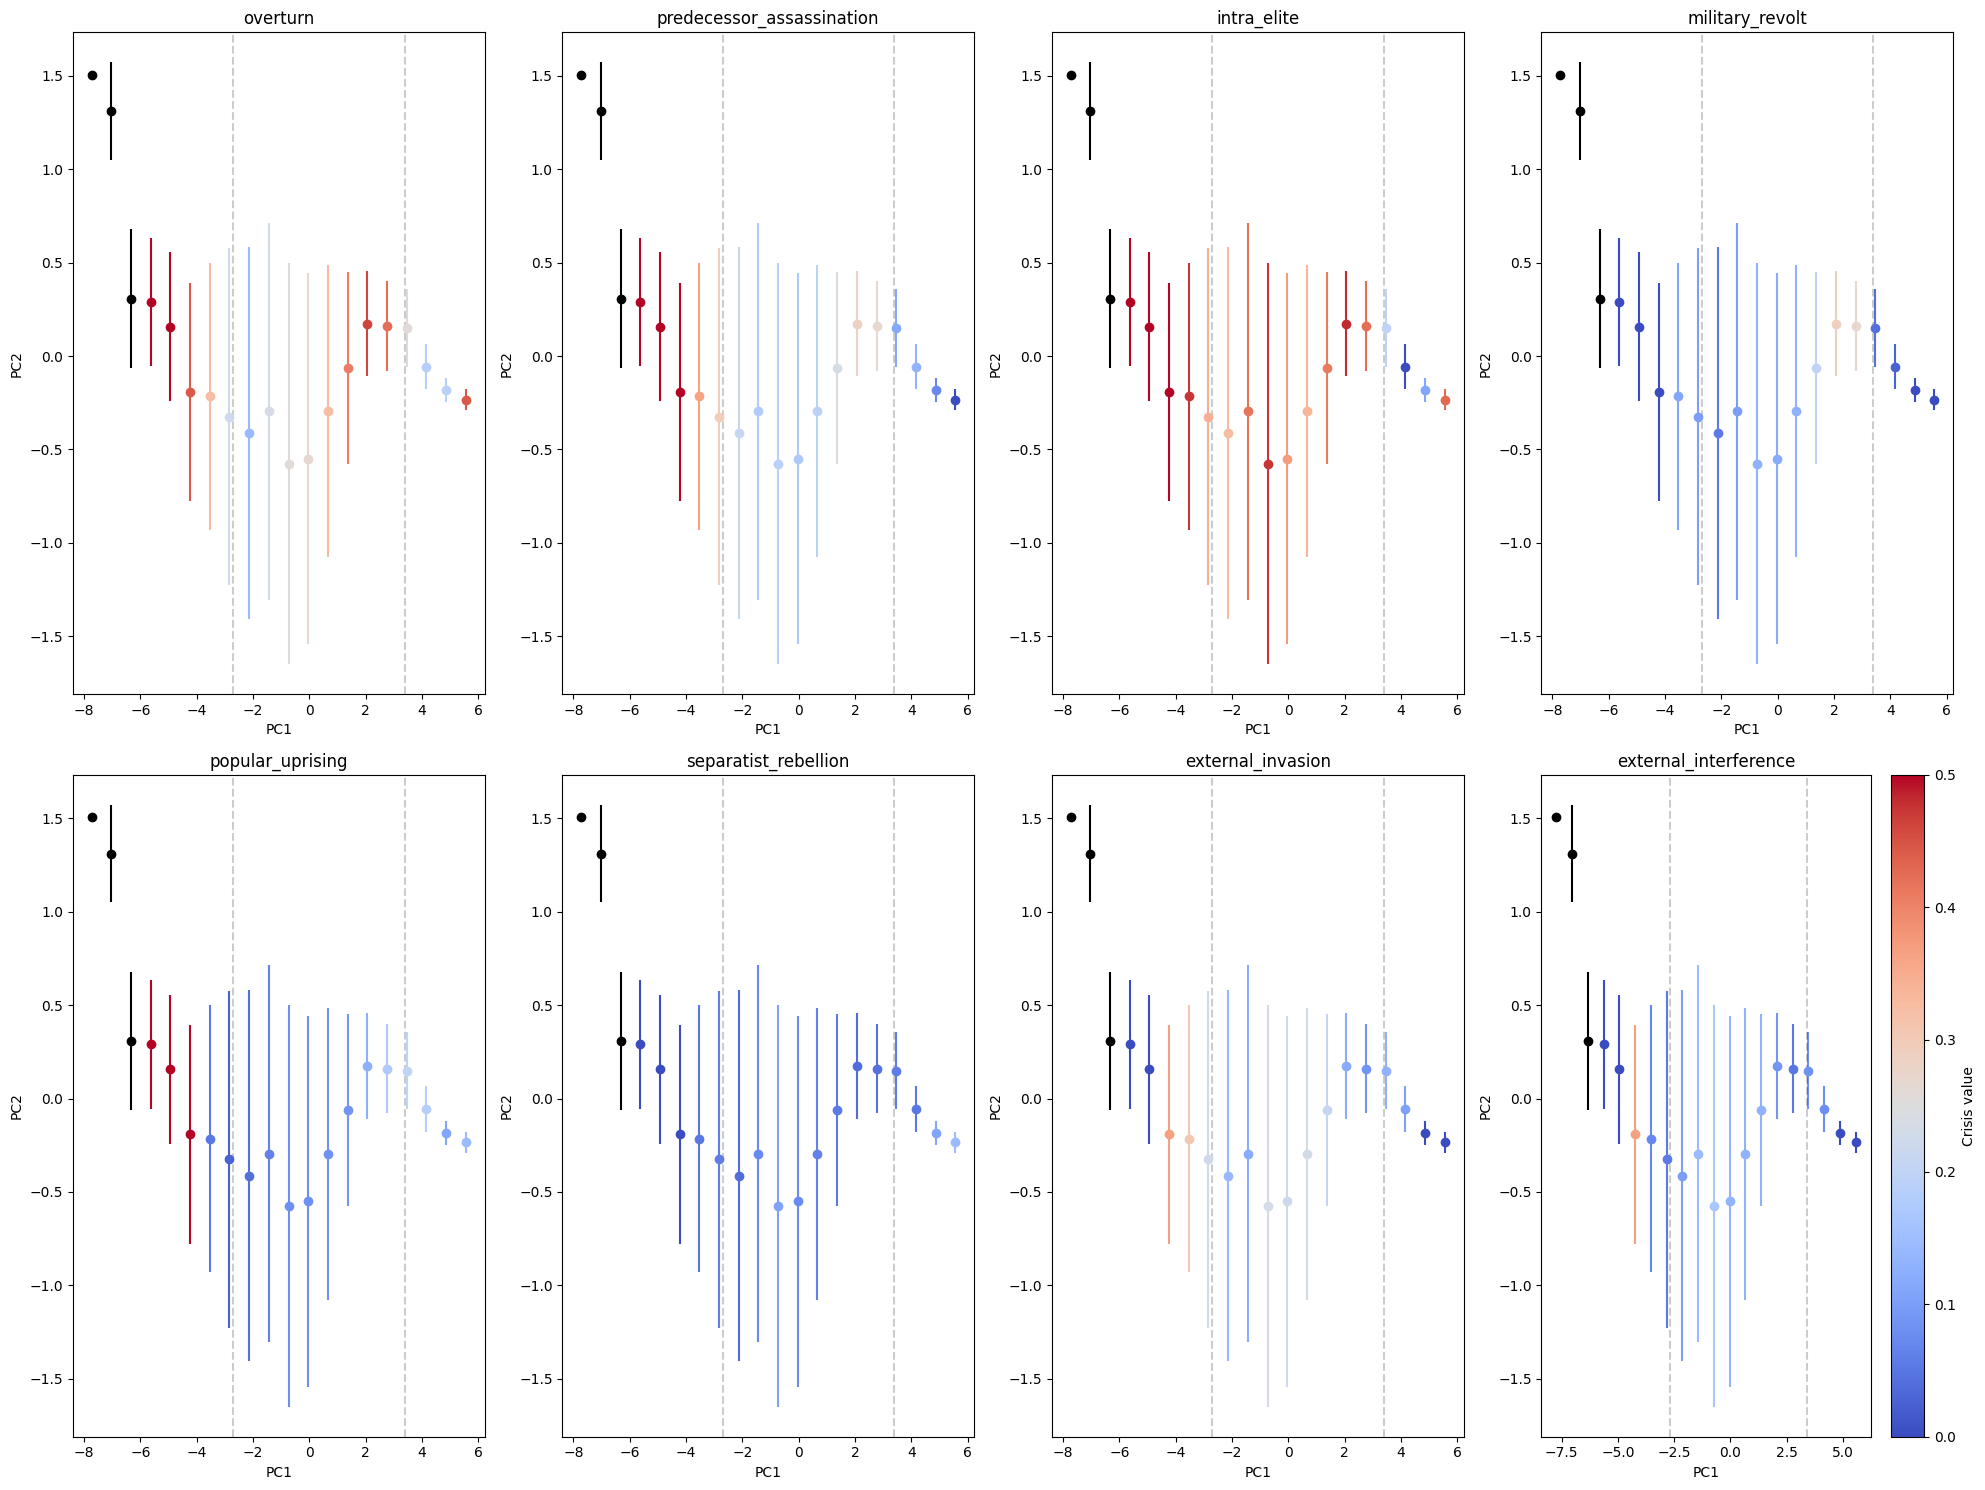

In [25]:
fig, axes = plt.subplots(2, 4, figsize=(20, 15))
axes = axes.flatten()
vmax = 0.5
for v in range(len(crisis_vars)):
    # Normalize the crisis values to use with a colormap
    norm = crisis / crisis.max()
    cmap = plt.get_cmap('coolwarm')

    # Plot the error bars with colors based on the crisis values
    for i in range(len(pc1)):
        axes[v].errorbar(pc1[i], pc2[i], yerr=pc2_std[i], fmt='o', color=cmap(crisis[v, i] / vmax))
        if pd.isna(crisis[v, i]):
            axes[v].errorbar(pc1[i], pc2[i], yerr=pc2_std[i], fmt='o', color='black')
    axes[v].set_xlabel('PC1')
    axes[v].set_ylabel('PC2')
    axes[v].set_title(crisis_vars[v])
    vlines = [-2.7,3.4]
    for vl in vlines:
        axes[v].axvline(vl, color='black', linestyle='--', alpha=0.2)

# Add a colorbar to the last axis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, vmax))
sm.set_array([])
fig.colorbar(sm, ax=axes[-1], orientation='vertical', label='Crisis value')
plt.tight_layout()
plt.show()

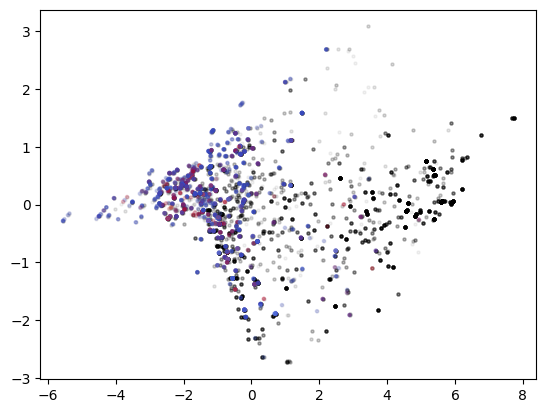

In [22]:
plt.scatter(-scv_imp.PC_1, scv_imp.PC_2, c='black', s=5, alpha=0.05)
plt.scatter(-scv_imp.PC_1, scv_imp.PC_2, c=scv_imp.predecessor_assassination, cmap='coolwarm', s=5, alpha=0.2)